In [2]:
import sys, traceback
print(sys.executable)
print(sys.version)
print(sys.version_info)

import math
import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes
from spectral_cube import LazyMask
from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc
from astropy.convolution import Gaussian1DKernel
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
from astrodendro.analysis import PPVStatistic
import os

print(astrodendro.__file__)

from matplotlib.patches import Ellipse
import copy
from tqdm import tqdm
import radio_beam
from astropy.table import Table

from scipy.optimize import curve_fit
from scipy.optimize import leastsq
#%matplotlib widget
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2

#Create a function that uses the dendrogram input to calculate all the quantities, and has the size and linewidth requirements of the Shetty paper
#Requires the computed dendrogram, the data from the line image, the velocity axis, and the data from the Continuum image, as well as metadata for the structures
#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
#Continuum is in Jansky/Beam, Line data should have the unit specified in the metadata as 'data_unit'
gal="GC"

dist_cmz = 8.178*10**-3*u.Mpc

def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata,ColD = True,beam_size=999,beam_req = 999999):
    SizeA,SigmaA,LuminA,CDA,SIDS,MOM0_FLUX,Distances,V_rms_err = [[],[],[],[]],[[],[],[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]
    print(metadata)
    
    d_copy= Dendrogram
    #catalog = astrodendro.ppv_catalog(d, metadata)
    if (gal =="GC"):
        center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
        dist_val=8.178*10**3
    else:
        center = SkyCoord('00h47m33.14s' ,'-25d17m17.52s',frame='icrs')
        dist_val=3.5*10**6
    
    center_ra_pix,center_dec_pix = int(metadata['wcsu'][:][:][0].world_to_pixel(center)[0]),int(metadata['wcsu'][:][:][0].world_to_pixel(center)[1])
    sliced= LineData[12]
    CubeShape = np.shape(sliced)
    for t in Dendrogram.all_structures: 

        I = t.indices()
        Cont = True
        if t.is_branch:
                if t.parent==None:
                    Cont=True
                else:
                    Cont = True
        
        sliced= LineData[12]
        CubeShape = np.shape(sliced)
        DataShape=[[0,0],[0,0]]#The part of the cube that actually has data
        for lmi in range(CubeShape[0]):
            allData=np.nansum(sliced[lmi])
            if(allData>0 or allData<0):
                DataShape[0][0] = lmi+3
                break
        for lmi in range(CubeShape[0]):
            allData=np.nansum(sliced[CubeShape[0] - lmi -1])
            if(allData>0 or allData<0):
                DataShape[0][1] = CubeShape[0] - lmi -3
                break
        for lmi in range(CubeShape[1]):
            allData=(sliced[DataShape[0][0],lmi])
            if(allData>0 or allData<0):
                DataShape[1][0] = lmi+3
                break
        for lmi in range(CubeShape[1]):
            allData=(sliced[DataShape[0][0],CubeShape[1] - lmi -1])
            if(allData>0 or allData<0):
                DataShape[1][1] = CubeShape[1] - lmi -3
                break

        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            s_radius = s.radius
            s_v_rms = s.v_rms
            if((float((s_radius*np.pi/180*dist_val/10**6/u.deg)))*10**6<beam_size*7 and (float((s_radius*np.pi/180*dist_val/10**6/u.deg)))*10**6>beam_size*beam_req and (float(s_v_rms/u.km*u.s))>.01):
            
            

                nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
                v_IWM = np.nansum(LineData[I]*(DataVel[I[0]])/u.km*u.s)/np.nansum(LineData[I])
                sig_Sh = np.sqrt(np.nansum(LineData[I]*((DataVel[I[0]])/u.km*u.s-v_IWM)**2)/np.nansum(LineData[I])) 
                
                #The flux from the continuum
                #Convert to Jansky from Jansky per beam:
                if(ColD ==True):
                    Cont_Flux=0

                    proj = tuple(set(zip(*tuple(I[i] for i in [1,2]))))
                    for lmi in range(len(proj)):

                        Cont_Flux+=ContData[proj[lmi]]
                    Cont_Flux=Cont_Flux/(metadata['beam_area_ratioc']*(2*np.sqrt(2*np.log(2))))*u.pix**2*u.beam/u.beam*u.Jy#SHould be input as Jansky /beam and will be converted to Jansky, then to unitless. The beam is changed from FWHM to Gaussian
                    Dust_Column = Flux_to_Mass(Cont_Flux)*Num_per_kg/((s_radius*np.pi/180*dist_cmz.value/u.deg)**2*(3.086*10**24)**2)/np.pi*(1.989*10**30*u.kg/u.M_sun)/u.kg
                    
                else:
                    Dust_Column=0
                if(str(Dust_Column) == str(np.nan) or str(Dust_Column)==str(np.inf)):
                    Dust_Column=0
                lum = Flux_to_Lum(s.flux)
                s_flux = s.flux

                Index = tuple(I[i] for i in [0,1,2])
                K_Km_s_Flux=np.nansum(LineData[Index]*metadata["velocity_scale"])#Find the total flux from the structures in K km/s, assuming the input data is in K as it should be, 
                
                
                
                
                Distance = np.sqrt((float(s.x_cen/u.pix)-center_ra_pix)**2+(float(s.y_cen/u.pix)- center_dec_pix)**2)*metadata['spatial_scale']*np.pi/180*dist_cmz.value*10**6/u.deg#pc dist from barycenter
                
                
                V_err= Get_V_rms_err(dend1=d_copy,idx=int(t.idx),struct=t,m=m,NF=1,iterations=5,metadata=metadata)
                
                
                if(t.is_leaf):

                    SizeA[0].append((float((s_radius*np.pi/180*dist_val/10**6/u.deg)))) #define size as astrodendro
                    SigmaA[0].append((float(s_v_rms/u.km*u.s)))#
                    CDA[0].append(float(Dust_Column))
                    LuminA[0].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[0].append(float(t.idx))
                    MOM0_FLUX[0].append(float(K_Km_s_Flux*u.s/u.km))
                    Distances[0].append(float(Distance))
                    V_rms_err[0].append(float(V_err))
                if(t.is_branch	):

                    SizeA[1].append((float((s_radius*np.pi/180*dist_val/10**6/u.deg)))) #define size as astrodendro
                    SigmaA[1].append((float(s_v_rms/u.km*u.s)))#
                    CDA[1].append(float(Dust_Column))
                    LuminA[1].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[1].append(float(t.idx))
                    MOM0_FLUX[1].append(float(K_Km_s_Flux*u.s/u.km))
                    Distances[1].append(float(Distance))
                    V_rms_err[1].append(float(V_err))
                del s
                    
                    
                    
    SizeA[0] = np.array(SizeA[0],dtype=type(1.))
    SizeA[1] = np.array(SizeA[1],dtype=type(1.))
    SizeA[2] = np.array(SizeA[2],dtype=type(1.))
    SizeA[3] = np.array(SizeA[3],dtype=type(1.))
    SigmaA[0] = np.array(SigmaA[0],dtype=type(1.))
    SigmaA[1] = np.array(SigmaA[1],dtype=type(1.))
    SigmaA[2] = np.array(SigmaA[2],dtype=type(1.))
    SigmaA[3] = np.array(SigmaA[3],dtype=type(1.))
    CDA[0] = np.array(CDA[0],dtype=type(1.))
    CDA[1] = np.array(CDA[1],dtype=type(1.))
    LuminA[0] = np.array(LuminA[0],dtype=type(1.))
    LuminA[1] = np.array(LuminA[1],dtype=type(1.))
    SIDS[0] = np.array(SIDS[0],dtype=type(1.))
    SIDS[1] = np.array(SIDS[1],dtype=type(1.))
    MOM0_FLUX[0] = np.array(MOM0_FLUX[0],dtype=type(1.))
    MOM0_FLUX[1] = np.array(MOM0_FLUX[1],dtype=type(1.))
    Distances[0] = np.array(Distances[0],dtype=type(1.))
    Distances[1] = np.array(Distances[1],dtype=type(1.))
    V_rms_err[0] = np.array(V_rms_err[0],dtype=type(1.))
    V_rms_err[1] = np.array(V_rms_err[1],dtype=type(1.))
    
    return np.array(SizeA),np.array(SigmaA),np.array(CDA),np.array(LuminA),np.array(SIDS),np.array(MOM0_FLUX),np.array(Distances),np.array(V_rms_err)

#Make a function to make an image 

#Data to plot, minimum of color bar, maximum, WCS projection for coords, and position of the image in the larger figure
def Make_Plot(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    
    if(gal=="NGC253"):
        pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
        pylab.ylabel('Declination',fontsize=20,labelpad=1)
    else:
        pylab.xlabel('Glon',fontsize=20,labelpad=1)                               
        pylab.ylabel('Glat',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=0.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
def Make_Plot_Anno(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show,pos1,pos2):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    if(gal=="NGC253"):
        pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
        pylab.ylabel('Declination',fontsize=20,labelpad=1)
    else:
        pylab.xlabel('Glon',fontsize=20,labelpad=1)                               
        pylab.ylabel('Glat',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
        
        
#Put this up here for the column density map
def Flux_to_Mass(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    if(gal=="NGC253"):
        L = 4*np.pi*(3.5*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    else:
        L = 4*np.pi*(8.178*10**-3*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    
    a_850 = 6.7*10**19*u.erg/u.s/u.Hz/u.M_sun #6.7+-1.7
    
    M_mol = L/a_850#Just in Solar mass*1.989*10**30*u.kg/u.M_sun #Determines mass of the cont for 850 in kg
    return M_mol
def Flux_to_Lum(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    if(gal=="NGC253"):
        L = 4*np.pi*(3.5*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    else:
        L = 4*np.pi*(8.178*10**-3*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    return L


def Get_V_rms_err(dend1,struct,idx,m,NF,iterations,metadata):
    
    
    vs=[]
    np.random.seed((99)**2*123)
    for llll in range(iterations):
        
        #print(llll)
        s = dend1.__getitem__(idx)
        #s = struct#copy.deepcopy(struct)
        #s2 = struct#copy.deepcopy(struct)
        npixels = np.product(np.shape(s.values()))
        #print(np.shape(s.values()),s.values())
        
        additional_noise = np.random.normal(0., m*NF, npixels)
        additional_noise = np.reshape(additional_noise, np.shape(s.values()))
        #add or subract noise to the values and calculate the v rms, them find the std of that array and
        # call that the uncertainty in v rms for a structure
        dat1P = dend1.data[s.indices()]
        dend1.data[s.indices()]+= additional_noise
        s = dend1.__getitem__(idx)
        vs.append(float(PPVStatistic(s,metadata=metadata).v_rms/u.km*u.s))
        dend1.data[s.indices()]= dat1P#reset the dend data
        
        dend1.data[s.indices()]-= additional_noise
        #s._values+=additional_noise
        #print(s.values(),s._values)
        
        #s2._values-=additional_noise
        s = dend1.__getitem__(idx)
        #print(dat1P[0],s._values[0],"kaasl")
        vs.append(float(PPVStatistic(s,metadata=metadata).v_rms/u.km*u.s))
        
        del s
        #del s2
        
    v_rms_std = np.nanstd(vs)
    #print(v_rms_std)
    return v_rms_std

#Return a cropped cube for some ra and dec, also crops the velocity axis if needed (0 for no crop)
def Crop(cube,WCS,Np1,Np2,BadVel,D2):
    NraDP1 = [int(WCS.world_to_pixel(Np1)[0]),int(WCS.world_to_pixel(Np1)[1])]
    NraDP2 = [int(WCS.world_to_pixel(Np2)[0]),int(WCS.world_to_pixel(Np2)[1])]
    if(D2==False):
        return cube[BadVel:np.shape(cube)[0]-BadVel,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    if(D2==True):
        return cube[NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]

    
def Read_Clusters(FileName):
    
    sh= len(np.genfromtxt(FileName,usecols=0))
    Data=[]
    for lmi in range(50):
        try:
            Data.append(np.genfromtxt(FileName,usecols=lmi,dtype=type("2d4m")))
            #print(np.genfromtxt(FileName,usecols=lmi,dtype=type("2d4m"),skip_header=1))
        except:
            pass
    return Data
def Find_Clusters_NGC(Data):
    for lmi in range(len(Data)):
        if "ID" in Data[lmi]:
            IDs= Data[lmi][1:9999]
        if "RA" in Data[lmi]: 
            RAs= Data[lmi][1:9999]
        if "Dec" in Data[lmi]:
            Decs= Data[lmi][1:9999]
        if "r_deconv" in Data[lmi]: 
            R_deconv= Data[lmi][1:9999]#pc
        if "glon" in Data[lmi]: 
            glons= Data[lmi][1:9999]#
        if "glat" in Data[lmi]: 
            glats= Data[lmi][1:9999]#
            
    return IDs,RAs,Decs,R_deconv
#Take the cont in Jy and find the HWHM from the structures in the catalog
def Find_Clusters(Data,wcs,Cont_Data,header):
    for lmi in range(len(Data)):
        if "ID" in Data[lmi]:
            IDs= Data[lmi][1:9999]
        if "RA" in Data[lmi]: 
            RAs= Data[lmi][1:9999]
        if "Dec" in Data[lmi]:
            Decs= Data[lmi][1:9999]
        if "r_deconv" in Data[lmi]: 
            R_deconv= Data[lmi][1:9999]#pc
        if "glon" in Data[lmi]: 
            glons= Data[lmi][1:9999]#
        if "glat" in Data[lmi]: 
            glats= Data[lmi][1:9999]#
        if "herschel_column" in Data[lmi]: 
            CD= (Data[lmi][1:9999])#pc
            
        if "flux_integrated" in Data[lmi]: 
            Flux_1p3mm= Data[lmi][1:9999]#pc
    #remove nan 
    for lmii in range(len(CD)):
        try:
            if CD[lmii]=='np.nan':
                CD= np.delete(CD, lmii)
                Flux_1p3mm= np.delete(Flux_1p3mm, lmii)
                IDs= np.delete(IDs, lmii)
                glats= np.delete(glats, lmii)
                glons= np.delete(glons, lmii)
                
        except:
            CD = np.array(CD,dtype=type(1.2**5))#float
            break
    glats_New=[]
    glons_New=[]
    CDs_New=[]
    IDs_New=[]
    Flux_1p3mm_New=[]

    #print(CD,sorted(CD),type(CD),type(CD[0]))
    nth = sorted(CD)[len(CD)-34]#34 most dense leaves
    #print(nth,"A",CD,sorted(CD))
    for lmj in range(len(CD)):
        if CD[lmj]>nth:
            glats_New.append(glats[lmj])
            glons_New.append(glons[lmj])
            CDs_New.append(CD[lmj])
            IDs_New.append(int(IDs[lmj]))
            Flux_1p3mm_New.append(Flux_1p3mm[lmj])
    HWHM_rad = []      
    #print(Flux_1p3mm_New,glats_New,glons_New,CDs_New,IDs_New)
    for lmi in range(len(CDs_New)):
        glat = glats_New[lmi]
        glon = glons_New[lmi]
        Flux = float(Flux_1p3mm_New[lmi])#INtegerated flux in jy
        
        Circle_R = 0
        distance = 8.178*10**-3*u.Mpc
        
        pixel_res = abs(header['cdelt1'])*np.pi/180*distance*10**6/u.Mpc*u.pc # cdelt in deg, goes to res in pc
        
        #sky = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
        sky = SkyCoord(l=float(glon)*u.deg, b=float(glat)*u.deg, frame='galactic')
        #center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
        p1,p2 = int(wcs.world_to_pixel(sky)[0]),int(wcs.world_to_pixel(sky)[1]) #Ra,dec
        
        while(True):
            Circle_R += .01
            #pixels=[(p1,p2)]
            pixels=[(p2,p1)]#Goes lat then long for the cont data
            #print(p1,p2)
            #print(np.shape(Cont_Data[p2-50:p2+50]))
            #print(np.shape(Cont_Data[50,p1-50:p1+50]))
            for lmii in range(np.shape(Cont_Data[p2-50:p2+50])[0]):
                for lmjj in range(np.shape(Cont_Data[p2-50+lmii,p1-50:p1+50])[0]):
                    #Find pixels within the circle around the center (excude the center since its there already)
                    #print(np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res,lmjj)
                    if np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res.value < Circle_R and lmjj!=50:
                        pixels.append((lmjj-50+p2,lmii-50+p1))#Goes lat then long
                        
            
            
            sum_flux=0
            for lmkk in range(len(pixels)):
                sum_flux += (Cont_Data[pixels[lmkk]])
            #print(p1,p2,glat,glon,np.shape(Cont_Data),pixels,Cont_Data[pixels[0]],Flux,sum_flux,Circle_R)
            if sum_flux>Flux/2:
                HWHM_rad.append(Circle_R)#Pc
                break
                
    return HWHM_rad,CDs_New,glons_New,glats_New,IDs_New

#Return masked data around clusters or one pc around clusters
def Mask_Clusters_NGC(HWHM,wcs,header,unmasked_data,ras,decs,One_Pc=False,One_Pc_Size=1,HWHM_Fac=1):
    
    Masked_Data=copy.deepcopy(unmasked_data)
    for lmi in range(len(HWHM)):
        ra = ras[lmi]
        dec = decs[lmi]
                
        Circle_R = HWHM[lmi]*HWHM_Fac
        if(One_Pc):
            
            Circle_R=One_Pc_Size
        distance = 3.5*u.Mpc
        
        pixel_res = abs(header['cdelt1'])*np.pi/180*distance*10**6/u.Mpc*u.pc # cdelt in deg, goes to res in pc
        
        #sky = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
        sky = SkyCoord(str(ra),str(dec), frame='icrs')
        #center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
        p1,p2 = int(wcs.world_to_pixel(sky)[0]),int(wcs.world_to_pixel(sky)[1]) #Ra,dec
        


        #pixels=[(p1,p2)]
        pixels=[(p2,p1)]#Goes lat then long for the cont data
        #print(p1,p2)
        #print(np.shape(Cont_Data[p2-50:p2+50]))
        #print(np.shape(Cont_Data[50,p1-50:p1+50]))
        for lmii in range(np.shape(unmasked_data[0,p2-50:p2+50])[0]):
            for lmjj in range(np.shape(unmasked_data[0,p2-50+lmii,p1-50:p1+50])[0]):
                #Find pixels within the circle around the center (excude the center since its there already)
                #print(np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res,lmjj)
                
                if np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res.value < Circle_R and lmjj!=50:
                    pixels.append((lmjj-50+p2,lmii-50+p1))#Goes lat then long
        
        for lmi in range(len(unmasked_data)):
            
            for lmj in range(len(pixels)):
                #print(Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]],lmi,pixels,np.shape(Masked_Data))
                Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]]=np.nan
                #print(Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]],lmi,pixels,np.shape(Masked_Data))
     
    return Masked_Data
            
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,1,True)
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,2,True)


def Mask_Clusters_CMZ(HWHM,wcs,header,unmasked_data,glons,glats,One_Pc=False,One_Pc_Size=1,HWHM_Fac=1):
    
    Masked_Data=copy.deepcopy(unmasked_data)
    for lmi in range(len(HWHM)):
        glon = glons[lmi]
        glat = glats[lmi]
                
        Circle_R = HWHM[lmi]*HWHM_Fac
        if(One_Pc):
            
            Circle_R=One_Pc_Size
        distance = dist_cmz
        
        pixel_res = abs(header['cdelt1'])*np.pi/180*distance*10**6/u.Mpc*u.pc # cdelt in deg, goes to res in pc
        
        #sky = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
        sky = SkyCoord(float(glon)*u.deg,float(glat)*u.deg, frame='galactic')
        #center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
        p1,p2 = int(wcs.world_to_pixel(sky)[0]),int(wcs.world_to_pixel(sky)[1]) #Ra,dec
        


        #pixels=[(p1,p2)]
        pixels=[(p2,p1)]#Goes lat then long for the cont data
        #print(p1,p2)
        #print(np.shape(Cont_Data[p2-50:p2+50]))
        #print(np.shape(Cont_Data[50,p1-50:p1+50]))
        for lmii in range(np.shape(unmasked_data[0,p2-50:p2+50])[0]):
            for lmjj in range(np.shape(unmasked_data[0,p2-50+lmii,p1-50:p1+50])[0]):
                #Find pixels within the circle around the center (excude the center since its there already)
                #print(np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res,lmjj)
                
                if np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res.value < Circle_R and lmjj!=50:
                    pixels.append((lmjj-50+p2,lmii-50+p1))#Goes lat then long
        
        for lmi in range(len(unmasked_data)):
            
            for lmj in range(len(pixels)):
                #print(Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]],lmi,pixels,np.shape(Masked_Data))
                Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]]=np.nan
                #print(Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]],lmi,pixels,np.shape(Masked_Data))
     
    return Masked_Data
            
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,1,True)
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,2,True)


/home/ben/miniconda3/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16
/home/ben/.local/lib/python3.8/site-packages/astrodendro/__init__.py


# Part 1: Updates

In [ ]:

#!py -m pip uninstall astropy
#!py -m pip install git+https://github.com/astropy/astropy
#!pip install emcee
!pip install corner
    
'''


!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git
!py -m pip install reproject
!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git 
!py -m pip install pyspeckit
!py -m pip install regions
!py -m pip install astrodendro
!py -m pip  install wcsaxes 
!py -m pip  install ipympl
!py -m pip install dask
!py -m pip install radio_beam
!py -m pip install casa_formats_io
#try:
#    !pip install casa_formats_io --no-binary :all:
#except:
#    !pip install casa_formats_io --no-cache --no-binary :all:

!py -m pip  install spectral_cube 
!py -m pip  install typing 
!py -m pip install mypy
!py -m pip  install typing_extensions 
'''

# Part 6: Reprojection

In [ ]:
files = ["CMZ_3mm_HCO+.fits"]

#Just Using HCO 1-0 right now


      
#FOV = [400,800]#pc
FOV = [70,360]#pc
gal="GC"
Min_res=4.3*u.pc#Smallest resolution


iterations = 5
Line_Name = '_CMZ_HCO_J1_0_4.3_start'

ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
#Beam_Sizes = np.linspace(Smallest_beam,Smallest_beam*iterations, np.diff(Smallest_beam,Smallest_beam*iterations)/iterations)
iter_factor = 1/5

for kl in range(iterations):
    Prime_Beam = Min_res*((kl*iter_factor+1))#Beam_Sizes[kl]
    
    #Need to break it up into 30-wide vel slices to do the reprojection (ram-draw too high)
    
    for i in range(0,300):
        print(kl,i)
        Cube_Name = str(Prime_Beam.value)+"pc_beam_"+str(i)+Line_Name+str(FOV[0])+"x"+str(FOV[1])+'pc.fits'
        sc = SpectralCube.read(files[0])  
    

        Nres=4.3*u.pc
        dist=8.178*10**3#pc
        res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
        print(res,"A")



        sc = sc[:,:,:]# Make a subcube

        #sc = sc[i*30:i*30+30,50:400,50:400]# Make a subcube
        #Put in the right system
        sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s

        vel,RA,Dec = sc_kms.world[:,0,0]

        while(vel[0]<-250*u.km/u.s):
            sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s


            sc_kms= sc_kms[i*15:i*15+15,:,:]# Make a subcube

            #Find the right velocity range
            vel,RA,Dec = sc_kms.world[:,0,0]

            i+=1
        if(vel[0]>250*u.km/u.s):
            print(vel[14])
            print("End Loop at",i)
            break

        
        try:
            sc = sc_kms.spectral_slab(-250. *u.km / u.s, 251. *u.km / u.s)  # Crop out velocities we don't care about    
            del sc_kms
            sc.allow_huge_operations=True    
            HI = sc.header
            Nres=Prime_Beam
            if(gal=="NGC253"):
                dist=3.5*10**6
            if(gal=="GC"):
                dist=8.178*10**3#pc
            res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
            
            beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
            
            
            sc.allow_huge_operations=True



            



            #Now that we have a circular beam, this can be done easily:
            #use some trig to make a rectangle at 33 deg, and allow pixels inside it.
            if(gal == 'GC'):

                cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
                cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
                #center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
                center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
                center_ra_pix,center_dec_pix = int(sc.wcs[:][:][0].world_to_pixel(center)[0]),int(sc.wcs[:][:][0].world_to_pixel(center)[1])

                print(center_dec_pix,center_ra_pix)

                print((sc.wcs[:][:][0].pixel_to_world(center_dec_pix,center_ra_pix)),center_dec_pix,center_ra_pix)
                PixFov = [int(FOV[0]/(cdelt_x/u.deg*np.pi/180*8.178*10**3))/2,int(FOV[1]/(cdelt_y/u.deg*np.pi/180*8.178*10**3))/2]


                pixels = np.zeros(np.shape(sc))           
                for lmi in range(np.shape(sc)[0]):
                    for lmj in range(np.shape(sc)[1]):
                        for lmk in range(np.shape(sc)[2]):

                            up_pixels = abs(lmj-center_dec_pix)#Should not be over the fov in the upwards direction (relative to 0 degrees)
                            side_pixels = abs(lmk-center_ra_pix)#Should not be over the fov in the side-side direction (relative to 0 degrees)

                            if(up_pixels<PixFov[0] and side_pixels<PixFov[1]):
                                #print(lmj,lmk,np.shape(sc))
                                pixels[lmi][lmj][lmk] = 1#good
                        #print("Up pix",up_pixels,"Up pix fov",PixFov[0],"side pix",side_pixels,"side pix fov",PixFov[1],"lmj (dec)",lmj,"lmk (ra)",lmk,"center dec pix",center_dec_pix,"center ra pix",center_ra_pix,cdelt_x_pc,cdelt_y_pc)

                bp = np.where(pixels!=1)
                #print(pixels)
                bp = np.where(pixels!=1)
                #Mask teh pixels outside the fov
                scCopy = sc.hdu
                #sc.hdu.data[bp]=9999#np.nan
                scCopy.data[bp]=np.nan
                sc = SpectralCube.read(scCopy)
                del scCopy


            #Get right size

            sc.allow_huge_operations=True
            datn = sc.hdu.data
            sx,sy,ex,ey=0,0,0,0
            for lmi in range(np.shape(datn[0,:,:])[0]):

                if(ey!=0 and sx!=0 and ex!=0 and sy!=0):
                    print("F",lmi)
                    break
                for lmj in range(np.shape(datn[0,:,:])[1]):

                    if(sx==0):            
                        if(np.nanmean(datn[0,lmi,:])>0 or np.nanmean(datn[0,lmi,:])<0):
                            sx=lmi


                    if(sy==0):
                        if(np.nanmean(datn[0,:,lmj])>0 or np.nanmean(datn[0,:,lmj])<0):
                            sy=lmj

                    if(ex==0):
                        if(np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])>0 or np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])<0):
                            ex=np.shape(datn[0,:,:])[0]-lmi-1

                    if(ey==0):
                        if(np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])>0 or np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])<0):
                            ey=np.shape(datn[0,:,:])[1]-lmj-1

                    if(ey!=0 and ex!=0 and sx!=0 and sy!=0):
                        break
            print(sx,ex,sy,ey)
            scP = sc[:,sx:ex,sy:ey]
            scP_Hdu=scP.hdu
            zeros=((scP_Hdu.data[:,:,:]==0))
            bp = np.where(zeros)
            scP_Hdu.data[bp]=np.nan
            sc = SpectralCube.read(scP_Hdu)

            
            
            try:
                sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
            except:
                cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
                cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
                if(cdelt_x>cdelt_y):
                    majorBase=cdelt_x
                    minorBase=cdelt_y
                elif(cdelt_x<cdelt_y):
                    majorBase=cdelt_y
                    minorBase=cdelt_x
                elif(cdelt_x==cdelt_y):
                    majorBase=cdelt_x
                    minorBase=cdelt_x
                BaseBeam = radio_beam.Beam(major=majorBase, minor=minorBase, pa=0*u.deg)

                sc = sc.with_beam(BaseBeam)

                beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
                print(BaseBeam,beam,"C")
                sc.allow_huge_operations=True
                print(sc.shape,np.nanmax(sc.hdu.data),'EA')
                #Requires me to edit convolve.py and set allow_huge =True
                sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
                print(np.shape(sc),"B")
            del scP_Hdu
            del zeros
            del scP
            del datn








            reheader = sc.header


            if(gal=="NGC253"):
                ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
                if sc.header['cdelt1']>0:
                    pix_x    = (res/ovs).to(u.degree).value
                    origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

                else:
                    pix_x    = -1.*(res/ovs).to(u.degree).value
                    origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

                if sc.header['cdelt2']>0:
                    pix_y    = (res/ovs).to(u.degree).value
                    origin_y = sc.latitude_extrema[0].to(u.degree).value
                else:
                    pix_y    = -1.*(res/ovs).to(u.degree).value
                    origin_y = sc.latitude_extrema[1].to(u.degree).value

                if gal=='NGC253':
                    npix_x   = int(np.ceil(np.diff(sc.longitude_extrema, n=1)[0]/np.abs(pix_x)).value)
                    npix_y   = int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)

            elif gal=='GC':
                ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
                
                if sc.header['cdelt1']>0:
                    #pix_x    = sc.header['cdelt1']/5#(res/5.).to(u.degree).value*10
                    pix_x    = (res/5.).to(u.degree).value
                    ##########REMEMBER TO DO THIS RIGHT
                    if(Line_Name!="_CMZ_CO_32323412tsfghsths"):
                        origin_x = 358.5
                    else:
                        origin_x = 357#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
                    #origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

                else:
                    #pix_x    = sc.header['cdelt1']/5#-1.*(res/5.).to(u.degree).value*10
                    pix_x    = -(res/5.).to(u.degree).value
                    origin_x = 3#(sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
                    #origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

                if sc.header['cdelt2']>0:
                    #pix_y    = sc.header['cdelt2']/5#(res/5.).to(u.degree).value*10
                    pix_y    = (res/5.).to(u.degree).value
                    origin_y = -1#sc.latitude_extrema[0].to(u.degree).value
                    #origin_y = sc.latitude_extrema[0].to(u.degree).value

                else:
                    #pix_y    = sc.header['cdelt2']/5#-1.*(res/5.).to(u.degree).value*10
                    pix_y    = -(res/5.).to(u.degree).value
                    origin_y = 1#sc.latitude_extrema[1].to(u.degree).value
                    #origin_y = sc.latitude_extrema[1].to(u.degree).value



                if gal=='GC':
                    #manually put in the size to correct for the 360->0 difference and just because it doesnt seem to work
                    print("LA",((sc.longitude_extrema[0])),(sc.longitude_extrema[1]-360*u.degree),np.abs(pix_x))
                    print("MA",sc.latitude_extrema,np.abs(pix_y))
                    #npix_x   =int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
                    #npix_y   =int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
                    npix_x   =int(6/np.abs(pix_x))
                    npix_y   =int(2/np.abs(pix_y))

                    print(npix_x,npix_y)


            #Correct the header to the expected pixels for the new res

            reheader['cdelt1'] = pix_x
            reheader['cdelt2'] = pix_y

            reheader['naxis1'] = npix_x
            reheader['naxis2'] = npix_y

            reheader['crval1'] = origin_x
            reheader['crval2'] = origin_y

            reheader['crpix1'] = 0
            reheader['crpix2'] = 0
            try:
                del reheader['lonpole']
                del reheader['latpole']
                del reheader['wcsaxes']#Dont need these anymore, maybe?
            except:
                pass

            # regrid cube to target pixel size
            sc_K_kms = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)

            new = SpectralCube(data=sc_K_kms.hdu.data,wcs = WCS(sc_K_kms.header),header=sc_K_kms.header)
            new.allow_huge_operations=True
            new = new*sc_K_kms[0][0][0].unit
            #do this because scs dont like being modified
            del sc_K_kms
            sc_K_kms = new
            del new

            print(np.nanmax(sc_K_kms),np.shape(sc_K_kms))#These should be a non zero float and the shape of the cube (30,~1000,~1000)
            del sc
            vel = np.arange(0,501,min_vel)*u.km/u.s
            NGC_CO_J3_2 = sc_K_kms
            del sc_K_kms
            NGC_CO_J3_2.allow_huge_operations=True

            #do this again to crop the extra pixels off
            sc=NGC_CO_J3_2
            datn = sc.hdu.data
            sx,sy,ex,ey=0,0,0,0
            for lmi in range(np.shape(datn[0,:,:])[0]):

                if(ey!=0 and sx!=0 and ex!=0 and sy!=0):
                    print("F",lmi)
                    break
                for lmj in range(np.shape(datn[0,:,:])[1]):

                    if(sx==0):            
                        if(np.nanmean(datn[0,lmi,:])>0 or np.nanmean(datn[0,lmi,:])<0):
                            sx=lmi


                    if(sy==0):
                        if(np.nanmean(datn[0,:,lmj])>0 or np.nanmean(datn[0,:,lmj])<0):
                            sy=lmj

                    if(ex==0):
                        if(np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])>0 or np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])<0):
                            ex=np.shape(datn[0,:,:])[0]-lmi-1

                    if(ey==0):
                        if(np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])>0 or np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])<0):
                            ey=np.shape(datn[0,:,:])[1]-lmj-1

                    if(ey!=0 and ex!=0 and sx!=0 and sy!=0):
                        break
            print(sx,ex,sy,ey)
            scP = sc[:,sx:ex,sy:ey]
            scP_Hdu=scP.hdu
            zeros=((scP_Hdu.data[:,:,:]==0))
            bp = np.where(zeros)
            scP_Hdu.data[bp]=np.nan
            sc = SpectralCube.read(scP_Hdu)

            sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
            del scP_Hdu
            del zeros
            del scP
            del datn

            #Write the intermediary cubes that will then be spliced together
            sc.write((Cube_Name),overwrite=True)      
            del NGC_CO_J3_2
            del sc
            gc.collect()######################################################################
        except Exception as e:
            print(e)
            print(kl,i)
            print("Failed")
            print("-"*60)
            traceback.print_exc(file=sys.stdout)



print("done")         

In [ ]:

#Splice 
#Just Using HCO 1-0 right now



FOV = [70,360]#pc
gal="GC"
Min_res=4.3*u.pc#Smallest resolution


iterations = 5
Line_Name = '_CMZ_HCO_J1_0_4.3_start'

ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
#Beam_Sizes = np.linspace(Smallest_beam,Smallest_beam*iterations, np.diff(Smallest_beam,Smallest_beam*iterations)/iterations)
iter_factor = 1/5


for kl in range(iterations):
      
    Prime_Beam = Min_res*((kl*iter_factor+1))#
    print(Prime_Beam)
    
    
        
    First =True   
    for i in range(0,50):
        
        try:
            Cube_Name_Load = str(Prime_Beam.value)+"pc_beam_"+str(i)+Line_Name+str(FOV[0])+"x"+str(FOV[1])+'pc.fits'


            sc=SpectralCube.read((Cube_Name_Load)) 
            
            vel,RA,Dec =sc.world[:,0,0]
            if (vel[0]>-250*u.km/u.s and vel[0]<250*u.km/u.s):

                print(np.shape(sc),Cube_Name_Load)
                print(sc.mask,type(sc.mask))




                if i==0:
                    reheader = sc.header
                    rewcs = sc.wcs


                print(type(sc))
                if First:
                    scW=SpectralCube.read((Cube_Name_Load))      
                    mask = scW.mask.include() #Need to create a mask because it doesn't get splcied
                if gal=='GC' and Line_Name== '_CMZ_CO_J3_2_4.3_start':
                    ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
                    Nres=Prime_Beam
                    reheaderx = sc.header
                    if(gal=="NGC253"):
                        dist=3.5*10**6
                    if(gal=="GC"):
                        dist=8.178*10**3#pc
                    res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
                    if sc.header['cdelt1']>0:
                        #pix_x    = sc.header['cdelt1']/5#(res/5.).to(u.degree).value*10
                        pix_x    = (res/5.).to(u.degree).value
                        origin_x = 357#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
                        #origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

                    else:
                        #pix_x    = sc.header['cdelt1']/5#-1.*(res/5.).to(u.degree).value*10
                        pix_x    = -(res/5.).to(u.degree).value
                        origin_x = 3#(sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
                        #origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

                    if sc.header['cdelt2']>0:
                        #pix_y    = sc.header['cdelt2']/5#(res/5.).to(u.degree).value*10
                        pix_y    = (res/5.).to(u.degree).value
                        origin_y = -1#sc.latitude_extrema[0].to(u.degree).value
                        #origin_y = sc.latitude_extrema[0].to(u.degree).value

                    else:
                        #pix_y    = sc.header['cdelt2']/5#-1.*(res/5.).to(u.degree).value*10
                        pix_y    = -(res/5.).to(u.degree).value
                        origin_y = 1#sc.latitude_extrema[1].to(u.degree).value
                        #origin_y = sc.latitude_extrema[1].to(u.degree).value



                    if gal=='GC':
                        #manually put in the size to correct for the 360->0 difference and just because it doesnt seem to work
                        print("LA",((sc.longitude_extrema[0])),(sc.longitude_extrema[1]-360*u.degree),np.abs(pix_x))
                        print("MA",sc.latitude_extrema,np.abs(pix_y))
                        #npix_x   =int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
                        #npix_y   =int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
                        npix_x   =int(6/np.abs(pix_x))
                        npix_y   =int(2/np.abs(pix_y))

                        print(npix_x,npix_y)


                        #Correct the header to the expected pixels for the new res

                        reheaderx['cdelt1'] = pix_x
                        reheaderx['cdelt2'] = pix_y

                        reheaderx['naxis1'] = npix_x
                        reheaderx['naxis2'] = npix_y

                        reheaderx['crval1'] = origin_x
                        reheaderx['crval2'] = origin_y

                        reheaderx['crpix1'] = 0
                        reheaderx['crpix2'] = 0
                        try:
                            del reheaderx['lonpole']
                            del reheaderx['latpole']
                            del reheaderx['wcsaxes']#Dont need these anymore, maybe?
                        except:
                            pass

                        # regrid cube to target pixel size
                        sc = sc.reproject(reheaderx, order='bilinear', use_memmap=True, filled=True)
                        if First:
                            scW = scW.reproject(reheaderx, order='bilinear', use_memmap=True, filled=True)
                            mask = scW.mask.include() #Need to create a mask because it doesn't get splcied


                if First:
                    First = False
                    scW = np.concatenate((scW[:].hdu.data,sc[:].hdu.data),dtype = type(sc))
                    print(type(scW))
                    mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))
                else:
                    scW = np.concatenate((scW[:],sc.hdu.data[:]),dtype = type(sc))
                    mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))


                print(np.shape(scW))
        except Exception as e:
            print(e)
            print(kl,i)
            print("Failed")
            print("-"*60)
            traceback.print_exc(file=sys.stdout)
    def duh(lol):
        gp = np.where(lol!=np.nan)
        lol[gp]=True
        return lol #Anywhere that has data will be unmasked
    reheader["NAXIS3"] = len(scW)https://www.twitch.tv/the6mastersmash
    Full_Mask = LazyMask(function = duh,data = mask, wcs = rewcs)
    scWsc = SpectralCube(data = scW,wcs = rewcs, header = reheader, mask = Full_Mask)#The spliced cube

    scWsc.allow_huge_operations=True
    scWsc = scWsc*sc[0][0][0].unit#Add unit back in
    del sc
    fwhm_factor = np.sqrt(8*np.log(2))

    scWsc.allow_huge_operations=True


    #scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
    #scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
    for km in range(iterations):
        scWsc_copy = scWsc
        vel_prime = min_vel*((km*iter_factor+1))
        Cube_Name_Save = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(vel_prime)+'_vel_res.fits'
        if(gal=="GC"):
            vel = np.arange(-250,251,vel_prime)*u.km/u.s    
        else:
            vel = np.arange(0,501,vel_prime)*u.km/u.s    

        G_width = np.sqrt(abs(scWsc.header["CDELT3"]**2-vel_prime**2))
        scWsc_copy = scWsc_copy.spectral_smooth(Gaussian1DKernel(G_width/fwhm_factor))#Preserves information from the pixels lost in downsampling

        scWsc_copy = scWsc_copy.spectral_interpolate(spectral_grid=vel) # Match velocities to -250 251 range 



        scWsc_copy.write(Cube_Name_Save,overwrite=True)
        gc.collect()
        #scWsc.write("NGC_Spliced_Reprojected_Whole_CO_32.fits",overwrite=True)
    del scWsc

print("done")    

In [ ]:
#Fix the Nans


FOV = [70,360]#pc
gal="GC"
Min_res=4.3*u.pc#Smallest resolution


iterations = 5
Line_Name = '_CMZ_HCO_J1_0_4.3_start'

ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
#Beam_Sizes = np.linspace(Smallest_beam,Smallest_beam*iterations, np.diff(Smallest_beam,Smallest_beam*iterations)/iterations)
iter_factor = 1/5




for kl in range(iterations):

    Prime_Beam = Min_res*((kl*iter_factor+1))#
    print(Prime_Beam)

    for km in range(iterations):
        vel_prime = min_vel*((km*iter_factor+1))


        Cube_Name_Load = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(vel_prime)+'_vel_res.fits'

        Cube_Name_Save=str("Cropped_"+Cube_Name_Load)

        sc = SpectralCube.read(Cube_Name_Load)
        datn = sc.hdu.data

        #Get right shape
        sx,sy,ex,ey=0,0,0,0
        for lmi in range(np.shape(datn[0,:,:])[0]):

            if(ey!=0 and sx!=0 and ex!=0 and sy!=0):
                print("F",lmi)
                break
            for lmj in range(np.shape(datn[0,:,:])[1]):

                if(sx==0):            
                    if(np.nanmean(datn[0,lmi,:])>0 or np.nanmean(datn[0,lmi,:])<0):
                        sx=lmi


                if(sy==0):
                    if(np.nanmean(datn[0,:,lmj])>0 or np.nanmean(datn[0,:,lmj])<0):
                        sy=lmj

                if(ex==0):
                    if(np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])>0 or np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])<0):
                        ex=np.shape(datn[0,:,:])[0]-lmi-1

                if(ey==0):
                    if(np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])>0 or np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])<0):
                        ey=np.shape(datn[0,:,:])[1]-lmj-1

                if(ey!=0 and ex!=0 and sx!=0 and sy!=0):
                    break
        print(sx,ex,sy,ey)


        sc = sc[:,sx:ex,sy:ey]

        sc_Hdu=sc.hdu
        zeros=((sc_Hdu.data[:,:,:]==0))
        bp = np.where(zeros)
        sc_Hdu.data[bp]=np.nan
        sc = SpectralCube.read(sc_Hdu)


        #Crop vel axis if needed

        sp=0
        for lmi in range(len(sc)):
            #Check to see if the slice has been repeated by the interpolation function
            if(np.round(np.nanmean(sc[lmi].hdu.data),5)==np.round(np.nanmean(sc[lmi+1].hdu.data),5)):

                sp = lmi+1
            else:
                print("A")
                print(lmi,np.nanmean(sc[lmi].hdu.data),np.nanmean(sc[lmi+1].hdu.data))
                break
        l = len(sc)-1
        ep=l
        for lmi in range(l):

            if(np.round(np.nanmean(sc[l-lmi].hdu.data),5)==np.round(np.nanmean(sc[l-lmi-1].hdu.data),5)):
                ep = l-lmi-1

            else:
                print("B",lmi)
                break

        print(sp,ep)#These are the start and stop slices where the actual unique data resides

        sc.allow_huge_operations=True
        sc = sc[sp:ep]


        sc.write(Cube_Name_Save,overwrite=True)
        del sc
        del sc_Hdu
        gc.collect()
        print(kl,km,'ready')
print("done")

In [ ]:
#match noise



iterations = 5
iter_factor = 1/5

ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
FOV = [70,360]#pc
Min_res=4.3*u.pc#Smallest resolution
Min_beam_req = 1/5

Params = [iterations,iter_factor,ovs,min_vel,FOV,Min_res,Min_beam_req]
savePath='/home/ben/Documents/Grad Stuff/MM data/Result Files'




Line_Name = '_CMZ_HCO_J1_0_4.3_start'
Line_Name_NGC = '_NGC_HCOp_J1_0_'



for kl in range(iterations):
      
    Prime_Beam = Min_res*((kl*iter_factor+1))#
    print(Prime_Beam)
    
    
    for km in range(iterations):
        vel_prime = min_vel*((km*iter_factor+1))


        #Make subcube

        Cube_Name_Load = "Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name_NGC+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(vel_prime)+'_vel_res.fits'
        path = Cube_Name_Load
        
        Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
        Qp.allow_huge_operations=True

        Qp = Qp.to(u.K)#Jy to Kelvin

        datn = Qp.hdu.data
        del Qp


        Non_nan=((datn[0,:,int(np.shape(datn)[2]/1.5):int(np.shape(datn)[2]-1)]>0)  | (datn[0,:,int(np.shape(datn)[2]/1.5):int(np.shape(datn)[2]-1)]<0 ))

        NGCCO32_Noise = (np.nanstd(datn[0,:,int(np.shape(datn)[2]/1.5):int(np.shape(datn)[2]-1)],where= Non_nan)) #Noise K
        print(np.shape(datn))
        del datn
        
        
        
        
        
        Cube_Name_Load = "Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(vel_prime)+'_vel_res.fits'
        print(Cube_Name_Load)
        Cube_Name_Save = "Noise_Matched_"+"Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(vel_prime)+'_vel_res.fits'
        path = Cube_Name_Load
        
        Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
        
        Qp.allow_huge_operations=True
        Q = Qp.to(u.K)#Jy to Kelvin
        del Qp
        datn=Q.hdu.data
        Non_nan=((datn[0,:,0:int(np.shape(datn)[2]/2)]>0)  | (datn[0,:,0:int(np.shape(datn)[2]/2)]<0 ))
        print(np.shape(datn))
        m = (np.nanstd(datn[0,:,0:int(np.shape(datn)[2]/2)],where= Non_nan)) #Noise K

        print(m,"Noise (K) matched to ",NGCCO32_Noise)





        npixels = np.product(Q.hdu.data.shape)

        target_noise = float(NGCCO32_Noise)
        actual_noise = m
        additional_sigma = np.sqrt(target_noise**2 - actual_noise**2)

        additional_noise = np.random.normal(0., additional_sigma, npixels)
        additional_noise = np.reshape(additional_noise, Q.hdu.data.shape)

        new_data = datn+additional_noise
        QCopy = Q.hdu
        QCopy.data = new_data
        Q = SpectralCube.read(QCopy)
        del QCopy

        
        Q.write(Cube_Name_Save,overwrite=True)
        del Q
        print(kl,km)
print("Doen")

# Part 8: Dendograms

In [3]:

#CO 3-2 all resses starting at 4.3


Num=0
Overlaps=0#4
Ram_Limiter=1#What percent of the cube my ram can handle
LineN="CMZ_HCO+_J1_0_all"
Name = "CMZ_HCO+_J1_0_all"
name = "CMZ_HCO+_J1_0_CM_Contours_all.jpeg"

Abs_Levels = ["All","None","No Clusters", "None (m)", "None All Channels"]



iterations = 5
iter_factor = 1/5
Line_Name = '_CMZ_HCO_J1_0_4.3_start'
ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
FOV = [70,360]#pc
Min_res=4.3*u.pc#Smallest resolution
Min_beam_req = 1/5

Params = [iterations,iter_factor,ovs,min_vel,FOV,Min_res,Min_beam_req]
savePath='/home/ben/Documents/Grad Stuff/MM data/Result Files'




NM= False

Line_Name = '_CMZ_HCO_J1_0_4.3_start'

if(NM):
    Line_Name_Save = '_CMZ_HCO_J1_0_4.3_start_NM'
else:
    Line_Name_Save=Line_Name

if(NM):
    Name_File = "CMZ_Names_New_All_Kinds_NM"
else:
    Name_File= "CMZ_Names_New_All_Kinds"

np.savetxt(Line_Name+"_Params", Params,fmt='%s')#[iterations,iter_factor ,Line_Name,Name,ovs,min_vel,FOV,Min_res,Min_beam_req]


4.3 pc
8.600000000000026e-07 MPC per pix


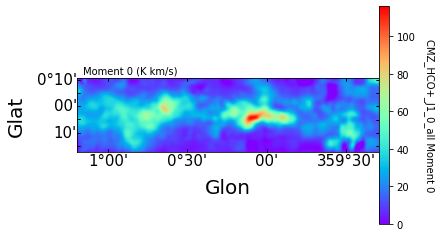

[[ 340.42418781  472.0115858   603.41322424 ... 2051.33625679
  2039.24612426 1871.34875281]
 [ 381.88273312  539.22660626  690.24323693 ... 2864.66487575
  2798.39060965 2484.81316339]
 [ 354.9477333   522.69413492  678.45249227 ... 3597.00364393
  3473.03870777 3013.33538309]
 ...
 [3123.2890189  2712.92847197 1553.98802689 ... 3988.8391317
  3935.42464369 3680.66393601]
 [3490.31492262 2781.42874222 1211.46197351 ... 4012.60272684
  3980.67579658 3747.83026227]
 [3553.67072296 2498.29264581  553.51027462 ... 3849.01778028
  3830.78625521 3621.33858297]]
0.016588423138571853 Unmatched Noise (K) Abs =  All


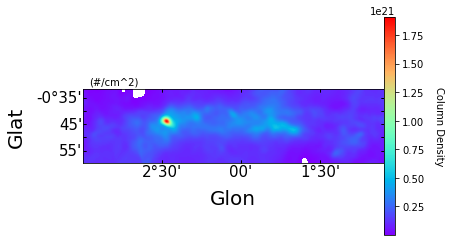

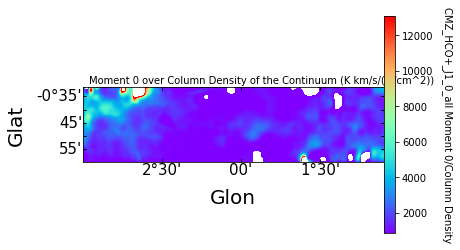

1.9467890125364784

1 89188526000.0 Hz 0.003361334371643276 m
1.3546864246547656e-07 <class 'float'>
108.45422681126364 arcsec 108.45422681126364 arcsec
28.327249999999815 pix2
0 0 0 0
0 0 0 0 0 0
CMZ_HCO+_J1_0_all_Cropped_4.3pc_beam__CMZ_HCO_J1_0_4.3_start70x360pc_3.3_vel_res_0.2_beam_size_req_1_times_beam_pixels_0.6_delt_factor_3.0_SNR.fits
0 0 0 0 0 1
CMZ_HCO+_J1_0_all_Cropped_4.3pc_beam__CMZ_HCO_J1_0_4.3_start70x360pc_3.3_vel_res_0.2_beam_size_req_1_times_beam_pixels_0.6_delt_factor_4.0_SNR.fits
0 0 0 0 0 2
CMZ_HCO+_J1_0_all_Cropped_4.3pc_beam__CMZ_HCO_J1_0_4.3_start70x360pc_3.3_vel_res_0.2_beam_size_req_1_times_beam_pixels_0.6_delt_factor_5.0_SNR.fits
0 0 0 0 0 3
CMZ_HCO+_J1_0_all_Cropped_4.3pc_beam__CMZ_HCO_J1_0_4.3_start70x360pc_3.3_vel_res_0.2_beam_size_req_1_times_beam_pixels_0.6_delt_factor_6.0_SNR.fits
0 0 0 0 0 4
CMZ_HCO+_J1_0_all_Cropped_4.3pc_beam__CMZ_HCO_J1_0_4.3_start70x360pc_3.3_vel_res_0.2_beam_size_req_1_times_beam_pixels_0.6_delt_factor_7.0_SNR.fits
0 0 0 0 1 0
CMZ

In [6]:




Abs_Level = Abs_Levels[0]



if gal =="GC":
    pathCont = '4.3pc_beam_CMZ_850um_Cont_140x800pc.fits'#'CMZ_Continuum_Splice.fits'
else:
    pathCont = 'Continuum_Reproject.fits'






for kl in range(1):
      
    Prime_Beam = Min_res*((kl*iter_factor+1))#
    print(Prime_Beam)
    
    
    for km in range(1):
        vel_prime = min_vel*((km*iter_factor+1))



        
        try:
            Names=list(np.load(Name_File+".npy",allow_pickle=True))
            
        except Exception as e:

            print(e)
            print("initialized names")
            Names = list(np.empty((20,iterations,iterations,iterations,iterations,iterations,iterations),dtype=object))
        

        #Continuum image
        scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
        #Put this up here for the column density map
        metadata = {}
        metadata["distance"] = dist_cmz
        arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
        arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
        beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
        beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
        beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
        metadata['beam_area_ratioc']=beam_area_ratioc
        pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
        print(pc_per_pixelc,"MPC per pix")

        #Make subcube


        if(NM):
            Cube_Name_Load = 'Noise_Matched_'+"Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(vel_prime)+'_vel_res.fits'
        else:
            Cube_Name_Load = "Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(vel_prime)+'_vel_res.fits'
        path = Cube_Name_Load
        
        Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
        Qp.allow_huge_operations=True

        Q = Qp.to(u.K)#Jy to Kelvin

        sc = Q.unmasked_copy()



        scW = sc.wcs[:][:][0]
        dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
        scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
        scF = scn
        datn = dat


        #m=.115

        #print(m,"Presumed Noise (K)")

        #Continuum image
        scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
        #Do the same thing to the continuum image
        scCont.allow_huge_operations=True
        scContW = scCont.reproject(scF.moment0().header)
        #m=.115


        scW = sc.wcs[:][:][0]

        


        #Do the same thing to the continuum image
        
        Continuum_Data  =scContW.hdu.data
        scWCS = scF.wcs[:][:][0]

        moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



        ######Moment 0 for both
        ######and cont
        Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


        cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number





        rm=moment_0_sub.hdu.data/cSD
        rmU = rm*u.K*u.km/u.s#Just put back in the units
        rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
        print(rmU)

        ######ratio

        bp = np.where(cSD<=.0001*10**22/u.cm**2)
        bp2 = np.where( moment_0_sub.hdu.data < .00022)
        Continuum_Data[bp] = np.nan
        cSD[bp]=np.nan
        rmU[bp]=np.nan
        rmU[bp2]=np.nan

        Non_nan=((datn[0,:,0:int(np.shape(datn)[2]/2)]>0)  | (datn[0,:,0:int(np.shape(datn)[2]/2)]<0 ))

        m = (np.nanstd(datn[0,:,0:int(np.shape(datn)[2]/2)],where= Non_nan)) #Noise K
        if(Abs_Level=="All"):
            pass
        if(Abs_Level=="None"):
            datn[np.where(datn<0)]=np.nan
        if(Abs_Level=="None (m)"):
            datn[np.where(datn<-m)]=np.nan
        if(Abs_Level=="None All Channels"):
            for lmi in range(len(datn)):
                bpP = np.where(datn[lmi]<-m)
                for lmj in range(len(datn)):
                    datn[lmj][bpP]=np.nan
        if(Abs_Level=="No Clusters"):
            
            #IDs,RAs,Decs,HWHM  =    np.genfromtxt("NGC_Clusters_"+"IDs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"RAs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"Decs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"HWHM"+"")
            
            HWHM_rad,CDs_New,glons_New,glats_New,IDs_New   =    np.genfromtxt("CMZ_Clusters_"+"HWHM"+""),np.genfromtxt("CMZ_Clusters_"+"CD"+""),np.genfromtxt("CMZ_Clusters_"+"Glon"+""),np.genfromtxt("CMZ_Clusters_"+"Glat"+""),np.genfromtxt("CMZ_Clusters_"+"IDs"+"")
            
            datn=  Mask_Clusters_CMZ(HWHM_rad,scWCS,scF.hdu.header,datn,glons_New,glats_New,One_Pc=False,One_Pc_Size=1,HWHM_Fac=3)

        print(m,"Unmatched Noise (K)", "Abs = ",Abs_Level)


        Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
        Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

        print(np.nanmin(rmU))



        header = scF.hdu.header
        print()
        #make metadata for the dendrogram

        try:
            freq = header["RESTFREQ"]*u.Hz#
            metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
            print(1,freq,metadata['wavelength'])
        except:
            freq = header["RESTFRQ"]*u.Hz#
            metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
        metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
        metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
        metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


        metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
        metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
        beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
        metadata['beam_area_ratio']=beam_area_ratio
        metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
        area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
        print(area_res,type(area_res))

        print(metadata['beam_minor'],metadata['beam_major'])
        print(beam_area_ratio)
        #metadata["wcs"] = wcs
        metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#u.km/u.s

        metadata["vaxis"]=0
        metadata["wcsu"]=scF.wcs


        for k3 in range(iterations):

            beam_req = Min_beam_req*(k3+1)
            
            for k4 in range(iterations):
                print(kl,km,k3,k4)
                pix_thresh_factor = k4+1
                for k6 in range(iterations):
                    delt_factor = (3/5+k6/5)
                    
                    for k7 in range(iterations):
                        noise_factor = (3/5+k7/5)
                        print(kl,km,k3,k4,k6,k7)
                        try:



                            Cube_Name_Save = Name+"_Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name_Save+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(vel_prime)+'_vel_res_'+str(beam_req)+"_beam_size_req_"+str(pix_thresh_factor)+'_times_beam_pixels_'+str(delt_factor)+"_delt_factor_"+str(noise_factor*5)+"_SNR.fits"


                            
                            Names[Num][kl][km][k3][k4][k6][k7] = Cube_Name_Save

                            NameS = (Cube_Name_Save+"Sigmas")
                            NameR = (Cube_Name_Save+"Radii")
                            NameCol = (Cube_Name_Save+"_Column")
                            NameLum = (Cube_Name_Save+"_Luminosities")

                            NameFlux = (Cube_Name_Save+"Flux_Dense")
                            NameRFF = (Cube_Name_Save+"Rad_For_Flux")

                            print(Cube_Name_Save)

                            #np.save("CMZ_Names_New_All_Kinds",Names)
                            
                            np.save(Name_File,Names)

                            
                            '''

                            d = astrodendro.Dendrogram.compute(datn,min_delta=m*delt_factor,min_value=m*5*(noise_factor),min_npix=beam_area_ratio.value*pix_thresh_factor) #The main culprit
                            #d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit

                            vel,RA,Dec = scF.world[:,0,0]
                            Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX,Distances,V_err = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata,beam_size=Prime_Beam.value,beam_req=beam_req)


                            ##Analyze dendograms
                            pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

                            sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


                            #Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


                            from scipy.optimize import curve_fit
                            from scipy.optimize import leastsq

                            def func(R,a,b):
                                return a*R**(b)
                            try:
                                popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
                            except:
                                popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
                            try:
                                poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
                            except:
                                poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]



                            Rcon = np.concatenate((Rads[0],Rads[1]))


                            Scon = np.concatenate((Sigmas[0],Sigmas[1]))
                            Scon2 = np.concatenate((Sigmas[2],Sigmas[3]))
                            print(np.shape(Rcon))

                            poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)










                            xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

                            ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])


                            LuminCon = np.concatenate((Lumin[0],Lumin[1]))
                            ColumnCon= np.concatenate((CD[0],CD[1]))

                            MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
                            DistancesCon= np.concatenate((Distances[0],Distances[1]))
                            print(Distances)

                            #Radius Luminosity fit
                            #Good pixels are places where the luminosity and therefore column density are above zero
                            gp = np.where(LuminCon>0)
                            print(np.shape(Rcon),np.shape(LuminCon))
                            lgp = LuminCon[gp]
                            radgp = Rcon[gp]*10**6

                            gp2 = np.where(ColumnCon>0)
                            cgp = ColumnCon[gp2]
                            rgp=Scon[gp2]**2/Rcon[gp2]/10**6
                            dgp=DistancesCon[gp2]
                            radgpFORRAT = Rcon[gp2]*10**6
                            siggpFORRAT = Scon[gp2]
                            lumFORRAT = LuminCon[gp2]
                            mom0FORRAT = MOM0FLUXcon[gp2]

                            #print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))

                            RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

                            xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
                            ysRL = func(xsRL,RLpopt[0],RLpopt[1])
                            #Column density to Size-linewidth
                            CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)

                            Dist_popt,Dist_pcov = curve_fit(func, np.array(DistancesCon,dtype='float64') ,np.array(Scon,dtype='float64'),maxfev=9999099,ftol = 10**-10)
                            Dist_popt2,Dist_pcov2 = curve_fit(func, np.array(dgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,ftol = 10**-10)

                            xsDist=np.linspace(np.nanmin(DistancesCon),np.nanmax(DistancesCon),50)
                            xsDist2=np.linspace(np.nanmin(dgp),np.nanmax(dgp),50)
                            ysDist=func(xsDist,Dist_popt[0],Dist_popt[1])
                            ysDist2=func(xsDist2,Dist_popt2[0],Dist_popt2[1])

                            gp3 = np.where(lumFORRAT>0)
                            lumFORRAT = lumFORRAT[gp3]
                            rgpFORRAT = rgp[gp3]
                            mom0FORRAT = mom0FORRAT[gp3]
                            
                            xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
                            ysCD = func(xsCD,CDpopt[0],CDpopt[1])


                            print(poptCon,pcovCon,"Size Linewidth All_structures:")
                            print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
                            print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))


                            print(RLpopt,RLpcov,"Radius to Luminosity:")
                            print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
                            print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))



                            print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
                            print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
                            print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))
                            
                            
                            
                            gp4=np.where(MOM0FLUXcon>0)
                            mom0FORFlux=MOM0FLUXcon[gp4]
                            radgpFORFlux=Rcon[gp4]*10**6
                            rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6
                            

                            

                            
                            fig = plt.figure(1,figsize=(40,40))


                            axAlpha = pylab.subplot(5, 5, 7)
                            axBeta = pylab.subplot(5, 5, 8)
                            axGamma = pylab.subplot(5, 5, 9)
                            axDelta = pylab.subplot(5, 5, 10)




                            p1=d.plotter()
                            p1.plot_tree(axAlpha)
                            axAlpha.set_xlabel("Structure")
                            axAlpha.set_ylabel("Flux (K)")
                            axAlpha.set_title("Whole data set")



                            #Plot contours for the top ten clusters


                            #scCropped =scF.moment0().hdu.data
                            scCropped =scF.moment0().hdu.data
                            scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
                            print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
                            scCropped[bp]=np.nan
                            axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
                            #axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
                            imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



                            ColumnCon= np.concatenate((CD[0],CD[1]))
                            SIDScon = np.concatenate((SIDS[0],SIDS[1]))
                            nth =0# sorted(CD[0])[len(CD[0])-20]

                            G1 = True

                            RA = axDelta.coords[0]                                                                  # 
                            Dec = axDelta.coords[1]

                            RA.set_ticks(size=-3)                                                                                      
                            Dec.set_ticks(size=-3) 
                            RA.set_ticklabel(exclude_overlapping=True) 
                            Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
                            pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
                            pylab.ylabel('Declination',fontsize=20,labelpad=1)
                            axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
                            cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
                            cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
                            cb.ax.tick_params(which = 'major', labelsize = 10)   
                            pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
                            pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

                            


                            
                            

                           



                            ax2 = pylab.subplot(5, 5, 1)
                            ax3 = pylab.subplot(5, 5, 2)
                            ax4 = pylab.subplot(5, 5, 3)

                            xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)


                            p = ax2.plot(xs,ysCon)





                            st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
                            ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

                            ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
                            ax2.set_yscale('log')
                            ax2.set_xscale('log')
                            ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
                            ax2.set_xlabel("Size (pc)",fontsize=12)
                            ax2.set_ylabel("Sigma (km/s)",fontsize=12)
                            ax2.legend(prop={'size': 12},loc="upper right")
                            ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

                            #gp = np.where(FRs>0)







                            xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




                            ax4.set_yscale('log')
                            ax4.set_xscale('log')

                            ax4.set_xlabel("Radius (pc)",fontsize=12)
                            ax4.set_ylabel("sig (km/s)",fontsize=12)
                            ax4.legend(prop={'size': 12},loc="upper right")






                            xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

                            ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
                            ax3.set_yscale('log')
                            ax3.set_xscale('log')
                            ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
                            ax3.set_xlabel("Rad (pc)",fontsize=12)
                            ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
                            ax3.legend(prop={'size': 12})

                            



                            ax5 = pylab.subplot(5, 5, 4)
                            ax6 = pylab.subplot(5, 5, 5)
                            ax7 = pylab.subplot(5, 5, 6)



                            xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
                            ax5.set_yscale('log')
                            ax5.set_xscale('log')
                            ax5.set_xlabel("Size (pc)",fontsize=12)
                            ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
                            ax5.legend(prop={'size': 12},loc="upper right")




                            xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
                            pF2 = ax6.plot(xsCD,ysCD)

                            ax6.set_yscale('log')
                            ax6.set_xscale('log')
                            ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
                            ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
                            ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
                            ax6.legend(prop={'size': 12},loc="upper right")
                            ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




                            xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
                            pFLLu2 = ax7.plot(xsRL,ysRL)

                            st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
                            ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
                            ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
                        
                            ax7.set_yscale('log')
                            ax7.set_xscale('log')
                            ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
                            ax7.set_xlabel("Radius (pc)",fontsize=9)
                            ax7.set_ylabel("Luminosity (erg)",fontsize=9)
                            ax7.legend(prop={'size': 12},loc="upper right")
                            ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


                            axLam = pylab.subplot(5, 5, 11)
                            lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
                            #Off by factors for area, simply using r^2

                            axLam.set_yscale('log')
                            axLam.set_xscale('log')
                            axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
                            axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
                            axLam.legend(prop={'size': 12},loc="upper right")
                            axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



                            axDelta = pylab.subplot(5, 5, 10)




                            

                            mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
                            #Off by factors for area, simply using r^2

                            axDelta.set_yscale('log')
                            axDelta.set_xscale('log')
                            axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
                            axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
                            axDelta.legend(prop={'size': 12},loc="upper right")
                            axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")
                            
                            
                            
                            axdis = pylab.subplot(5, 5, 12)
                            axdis2 = pylab.subplot(5, 5, 13)
                            axdis.scatter(DistancesCon,Scon)
                            axdis2.scatter(dgp,rgp)
                            axdis.plot(xsDist,ysDist)
                            axdis2.plot(xsDist2,ysDist2)
                            axdis2.set_yscale('log')
                            axdis2.set_xscale('log')
                            axdis.set_yscale('log')
                            axdis.set_xscale('log')

                            pylab.show()









                            v1 = d.viewer()
                            v1.show()

                            #Must use text because np load is broken
                            if(Abs_Level=="All"):
                                Suffix=''
                            if(Abs_Level=="None"):
                                Suffix='_NA'
                            if(Abs_Level=="No Clusters"):
                                Suffix='_No_Clusters'
                            if(Abs_Level=="None (m)"):
                                Suffix='None_m'
                            if(Abs_Level=="None All Channels"):
                                Suffix='None_All_Channels'






                            np.savetxt(os.path.join(savePath,NameCol+"_Leaves"+Suffix), CD[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameCol+"_Branches"+Suffix), CD[1],fmt='%s')



                            np.savetxt(os.path.join(savePath,NameLum+"_Leaves"+Suffix), Lumin[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameLum+"_Branches"+Suffix), Lumin[1],fmt='%s')





                            np.savetxt(os.path.join(savePath,NameS+"_Leaves"+Suffix), Sigmas[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameS+"_Branches"+Suffix), Sigmas[1],fmt='%s')



                            np.savetxt(os.path.join(savePath,NameR+"_Leaves"+Suffix), Rads[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameR+"_Branches"+Suffix), Rads[1],fmt='%s')


                            np.savetxt(os.path.join(savePath,NameFlux+"_Leaves"+Suffix), MOM0FLUX[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameFlux+"_Branches"+Suffix), MOM0FLUX[1],fmt='%s')



                            np.savetxt(os.path.join(savePath,Cube_Name_Save+"Distances_Leaves"+Suffix), Distances[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,Cube_Name_Save+"Distances_Branches"+Suffix), Distances[1],fmt='%s')






                            np.savetxt(os.path.join(savePath,Cube_Name_Save+"V_err_Leaves"+Suffix), V_err[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,Cube_Name_Save+"V_err_Branches"+Suffix), V_err[1],fmt='%s')

                            SIDS=np.concatenate((SIDS[0],SIDS[1]))

                            print(SIDS[len(SIDS)-3:len(SIDS)-1])

                        except Exception as e:
                            print(e)
                            print(kl,km,k3,k4)
                            print("Failed")
                            print("-"*60)
                            traceback.print_exc(file=sys.stdout)

                            if(Abs_Level=="All"):
                                Suffix=''
                            if(Abs_Level=="None"):
                                Suffix='_NA'
                            if(Abs_Level=="No Clusters"):
                                Suffix='_No_Clusters'
                            if(Abs_Level=="None (m)"):
                                Suffix='None_m'
                            if(Abs_Level=="None All Channels"):
                                Suffix='None_All_Channels'
                            nans = [[np.nan,np.nan],[np.nan,np.nan]]



                            np.savetxt(os.path.join(savePath,NameCol+"_Leaves"+Suffix), nans[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameCol+"_Branches"+Suffix), nans[1],fmt='%s')



                            np.savetxt(os.path.join(savePath,NameLum+"_Leaves"+Suffix), nans[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameLum+"_Branches"+Suffix), nans[1],fmt='%s')





                            np.savetxt(os.path.join(savePath,NameS+"_Leaves"+Suffix), nans[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameS+"_Branches"+Suffix), nans[1],fmt='%s')



                            np.savetxt(os.path.join(savePath,NameR+"_Leaves"+Suffix), nans[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameR+"_Branches"+Suffix), nans[1],fmt='%s')


                            np.savetxt(os.path.join(savePath,NameFlux+"_Leaves"+Suffix), nans[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameFlux+"_Branches"+Suffix), nans[1],fmt='%s')



                            np.savetxt(os.path.join(savePath,Cube_Name_Save+"Distances_Leaves"+Suffix), nans[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,Cube_Name_Save+"Distances_Branches"+Suffix), nans[1],fmt='%s')






                            np.savetxt(os.path.join(savePath,Cube_Name_Save+"V_err_Leaves"+Suffix), nans[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,Cube_Name_Save+"V_err_Branches"+Suffix), nans[1],fmt='%s')
                            '''
                        except:
                            pass
                            
                            


In [ ]:
#FIX NAMES



Abs_Level = Abs_Levels[0]



if gal =="GC":
    pathCont = '4.3pc_beam_CMZ_850um_Cont_140x800pc.fits'#'CMZ_Continuum_Splice.fits'
else:
    pathCont = 'Continuum_Reproject.fits'






for kl in range(1):
      
    Prime_Beam = Min_res*((kl*iter_factor+1))#
    print(Prime_Beam)
    
    
    for km in range(1):
        vel_prime = min_vel*((km*iter_factor+1))



        
        try:
            Names=list(np.load(Name_File+".npy",allow_pickle=True))
            
        except Exception as e:

            print(e)
            print("initialized names")
            Names = list(np.empty((20,iterations,iterations,iterations,iterations,iterations,iterations),dtype=object))
        

        #Continuum image
        scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
        #Put this up here for the column density map
        metadata = {}
        metadata["distance"] = dist_cmz
        arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
        arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
        beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
        beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
        beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
        metadata['beam_area_ratioc']=beam_area_ratioc
        pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
        print(pc_per_pixelc,"MPC per pix")

        #Make subcube


        if(NM):
            Cube_Name_Load = 'Noise_Matched_'+"Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(vel_prime)+'_vel_res.fits'
        else:
            Cube_Name_Load = "Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(vel_prime)+'_vel_res.fits'
        path = Cube_Name_Load
        
        Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
        Qp.allow_huge_operations=True

        Q = Qp.to(u.K)#Jy to Kelvin

        sc = Q.unmasked_copy()



        scW = sc.wcs[:][:][0]
        dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
        scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
        scF = scn
        datn = dat


        #m=.115

        #print(m,"Presumed Noise (K)")

        #Continuum image
        scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
        #Do the same thing to the continuum image
        scCont.allow_huge_operations=True
        scContW = scCont.reproject(scF.moment0().header)
        #m=.115


        scW = sc.wcs[:][:][0]

        


        #Do the same thing to the continuum image
        
        Continuum_Data  =scContW.hdu.data
        scWCS = scF.wcs[:][:][0]

        moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



        ######Moment 0 for both
        ######and cont
        Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


        cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number





        rm=moment_0_sub.hdu.data/cSD
        rmU = rm*u.K*u.km/u.s#Just put back in the units
        rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
        print(rmU)

        ######ratio

        bp = np.where(cSD<=.0001*10**22/u.cm**2)
        bp2 = np.where( moment_0_sub.hdu.data < .00022)
        Continuum_Data[bp] = np.nan
        cSD[bp]=np.nan
        rmU[bp]=np.nan
        rmU[bp2]=np.nan

        Non_nan=((datn[0,:,0:int(np.shape(datn)[2]/2)]>0)  | (datn[0,:,0:int(np.shape(datn)[2]/2)]<0 ))

        m = (np.nanstd(datn[0,:,0:int(np.shape(datn)[2]/2)],where= Non_nan)) #Noise K
        if(Abs_Level=="All"):
            pass
        if(Abs_Level=="None"):
            datn[np.where(datn<0)]=np.nan
        if(Abs_Level=="None (m)"):
            datn[np.where(datn<-m)]=np.nan
        if(Abs_Level=="None All Channels"):
            for lmi in range(len(datn)):
                bpP = np.where(datn[lmi]<-m)
                for lmj in range(len(datn)):
                    datn[lmj][bpP]=np.nan
        if(Abs_Level=="No Clusters"):
            
            #IDs,RAs,Decs,HWHM  =    np.genfromtxt("NGC_Clusters_"+"IDs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"RAs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"Decs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"HWHM"+"")
            
            HWHM_rad,CDs_New,glons_New,glats_New,IDs_New   =    np.genfromtxt("CMZ_Clusters_"+"HWHM"+""),np.genfromtxt("CMZ_Clusters_"+"CD"+""),np.genfromtxt("CMZ_Clusters_"+"Glon"+""),np.genfromtxt("CMZ_Clusters_"+"Glat"+""),np.genfromtxt("CMZ_Clusters_"+"IDs"+"")
            
            datn=  Mask_Clusters_CMZ(HWHM_rad,scWCS,scF.hdu.header,datn,glons_New,glats_New,One_Pc=False,One_Pc_Size=1,HWHM_Fac=3)

        print(m,"Unmatched Noise (K)", "Abs = ",Abs_Level)


        Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
        Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

        print(np.nanmin(rmU))



        header = scF.hdu.header
        print()
        #make metadata for the dendrogram

        try:
            freq = header["RESTFREQ"]*u.Hz#
            metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
            print(1,freq,metadata['wavelength'])
        except:
            freq = header["RESTFRQ"]*u.Hz#
            metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
        metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
        metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
        metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


        metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
        metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
        beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
        metadata['beam_area_ratio']=beam_area_ratio
        metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
        area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
        print(area_res,type(area_res))

        print(metadata['beam_minor'],metadata['beam_major'])
        print(beam_area_ratio)
        #metadata["wcs"] = wcs
        metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#u.km/u.s

        metadata["vaxis"]=0
        metadata["wcsu"]=scF.wcs


        for k3 in range(iterations):

            beam_req = Min_beam_req*(k3+1)
            
            for k4 in range(iterations):
                print(kl,km,k3,k4)
                pix_thresh_factor = k4+1
                for k6 in range(iterations):
                    delt_factor = (3/5+k6/5)
                    
                    for k7 in range(iterations):
                        noise_factor = (3/5+k7/5)
                        print(kl,km,k3,k4,k6,k7)
                        try:



                            Cube_Name_Save = Name+"_Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name_Save+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(vel_prime)+'_vel_res_'+str(beam_req)+"_beam_size_req_"+str(pix_thresh_factor)+'_times_beam_pixels_'+str(delt_factor)+"_delt_factor_"+str(noise_factor*5)+"_SNR.fits"


                            
                            Names[Num][kl][km][k3][k4][k6][k7] = Cube_Name_Save

                            NameS = (Cube_Name_Save+"Sigmas")
                            NameR = (Cube_Name_Save+"Radii")
                            NameCol = (Cube_Name_Save+"_Column")
                            NameLum = (Cube_Name_Save+"_Luminosities")

                            NameFlux = (Cube_Name_Save+"Flux_Dense")
                            NameRFF = (Cube_Name_Save+"Rad_For_Flux")

                            print(Cube_Name_Save)

                            #np.save("CMZ_Names_New_All_Kinds",Names)
                            
                            np.save(Name_File,Names)

                            
                            '''

                            d = astrodendro.Dendrogram.compute(datn,min_delta=m*delt_factor,min_value=m*5*(noise_factor),min_npix=beam_area_ratio.value*pix_thresh_factor) #The main culprit
                            #d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit

                            vel,RA,Dec = scF.world[:,0,0]
                            Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX,Distances,V_err = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata,beam_size=Prime_Beam.value,beam_req=beam_req)


                            ##Analyze dendograms
                            pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

                            sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


                            #Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


                            from scipy.optimize import curve_fit
                            from scipy.optimize import leastsq

                            def func(R,a,b):
                                return a*R**(b)
                            try:
                                popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
                            except:
                                popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
                            try:
                                poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
                            except:
                                poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]



                            Rcon = np.concatenate((Rads[0],Rads[1]))


                            Scon = np.concatenate((Sigmas[0],Sigmas[1]))
                            Scon2 = np.concatenate((Sigmas[2],Sigmas[3]))
                            print(np.shape(Rcon))

                            poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)










                            xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

                            ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])


                            LuminCon = np.concatenate((Lumin[0],Lumin[1]))
                            ColumnCon= np.concatenate((CD[0],CD[1]))

                            MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
                            DistancesCon= np.concatenate((Distances[0],Distances[1]))
                            print(Distances)

                            #Radius Luminosity fit
                            #Good pixels are places where the luminosity and therefore column density are above zero
                            gp = np.where(LuminCon>0)
                            print(np.shape(Rcon),np.shape(LuminCon))
                            lgp = LuminCon[gp]
                            radgp = Rcon[gp]*10**6

                            gp2 = np.where(ColumnCon>0)
                            cgp = ColumnCon[gp2]
                            rgp=Scon[gp2]**2/Rcon[gp2]/10**6
                            dgp=DistancesCon[gp2]
                            radgpFORRAT = Rcon[gp2]*10**6
                            siggpFORRAT = Scon[gp2]
                            lumFORRAT = LuminCon[gp2]
                            mom0FORRAT = MOM0FLUXcon[gp2]

                            #print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))

                            RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

                            xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
                            ysRL = func(xsRL,RLpopt[0],RLpopt[1])
                            #Column density to Size-linewidth
                            CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)

                            Dist_popt,Dist_pcov = curve_fit(func, np.array(DistancesCon,dtype='float64') ,np.array(Scon,dtype='float64'),maxfev=9999099,ftol = 10**-10)
                            Dist_popt2,Dist_pcov2 = curve_fit(func, np.array(dgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,ftol = 10**-10)

                            xsDist=np.linspace(np.nanmin(DistancesCon),np.nanmax(DistancesCon),50)
                            xsDist2=np.linspace(np.nanmin(dgp),np.nanmax(dgp),50)
                            ysDist=func(xsDist,Dist_popt[0],Dist_popt[1])
                            ysDist2=func(xsDist2,Dist_popt2[0],Dist_popt2[1])

                            gp3 = np.where(lumFORRAT>0)
                            lumFORRAT = lumFORRAT[gp3]
                            rgpFORRAT = rgp[gp3]
                            mom0FORRAT = mom0FORRAT[gp3]
                            
                            xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
                            ysCD = func(xsCD,CDpopt[0],CDpopt[1])


                            print(poptCon,pcovCon,"Size Linewidth All_structures:")
                            print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
                            print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))


                            print(RLpopt,RLpcov,"Radius to Luminosity:")
                            print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
                            print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))



                            print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
                            print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
                            print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))
                            
                            
                            
                            gp4=np.where(MOM0FLUXcon>0)
                            mom0FORFlux=MOM0FLUXcon[gp4]
                            radgpFORFlux=Rcon[gp4]*10**6
                            rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6
                            

                            

                            
                            fig = plt.figure(1,figsize=(40,40))


                            axAlpha = pylab.subplot(5, 5, 7)
                            axBeta = pylab.subplot(5, 5, 8)
                            axGamma = pylab.subplot(5, 5, 9)
                            axDelta = pylab.subplot(5, 5, 10)




                            p1=d.plotter()
                            p1.plot_tree(axAlpha)
                            axAlpha.set_xlabel("Structure")
                            axAlpha.set_ylabel("Flux (K)")
                            axAlpha.set_title("Whole data set")



                            #Plot contours for the top ten clusters


                            #scCropped =scF.moment0().hdu.data
                            scCropped =scF.moment0().hdu.data
                            scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
                            print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
                            scCropped[bp]=np.nan
                            axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
                            #axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
                            imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



                            ColumnCon= np.concatenate((CD[0],CD[1]))
                            SIDScon = np.concatenate((SIDS[0],SIDS[1]))
                            nth =0# sorted(CD[0])[len(CD[0])-20]

                            G1 = True

                            RA = axDelta.coords[0]                                                                  # 
                            Dec = axDelta.coords[1]

                            RA.set_ticks(size=-3)                                                                                      
                            Dec.set_ticks(size=-3) 
                            RA.set_ticklabel(exclude_overlapping=True) 
                            Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
                            pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
                            pylab.ylabel('Declination',fontsize=20,labelpad=1)
                            axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
                            cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
                            cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
                            cb.ax.tick_params(which = 'major', labelsize = 10)   
                            pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
                            pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

                            


                            
                            

                           



                            ax2 = pylab.subplot(5, 5, 1)
                            ax3 = pylab.subplot(5, 5, 2)
                            ax4 = pylab.subplot(5, 5, 3)

                            xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)


                            p = ax2.plot(xs,ysCon)





                            st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
                            ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

                            ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
                            ax2.set_yscale('log')
                            ax2.set_xscale('log')
                            ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
                            ax2.set_xlabel("Size (pc)",fontsize=12)
                            ax2.set_ylabel("Sigma (km/s)",fontsize=12)
                            ax2.legend(prop={'size': 12},loc="upper right")
                            ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

                            #gp = np.where(FRs>0)







                            xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




                            ax4.set_yscale('log')
                            ax4.set_xscale('log')

                            ax4.set_xlabel("Radius (pc)",fontsize=12)
                            ax4.set_ylabel("sig (km/s)",fontsize=12)
                            ax4.legend(prop={'size': 12},loc="upper right")






                            xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

                            ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
                            ax3.set_yscale('log')
                            ax3.set_xscale('log')
                            ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
                            ax3.set_xlabel("Rad (pc)",fontsize=12)
                            ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
                            ax3.legend(prop={'size': 12})

                            



                            ax5 = pylab.subplot(5, 5, 4)
                            ax6 = pylab.subplot(5, 5, 5)
                            ax7 = pylab.subplot(5, 5, 6)



                            xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
                            ax5.set_yscale('log')
                            ax5.set_xscale('log')
                            ax5.set_xlabel("Size (pc)",fontsize=12)
                            ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
                            ax5.legend(prop={'size': 12},loc="upper right")




                            xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
                            pF2 = ax6.plot(xsCD,ysCD)

                            ax6.set_yscale('log')
                            ax6.set_xscale('log')
                            ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
                            ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
                            ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
                            ax6.legend(prop={'size': 12},loc="upper right")
                            ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




                            xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
                            pFLLu2 = ax7.plot(xsRL,ysRL)

                            st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
                            ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
                            ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
                        
                            ax7.set_yscale('log')
                            ax7.set_xscale('log')
                            ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
                            ax7.set_xlabel("Radius (pc)",fontsize=9)
                            ax7.set_ylabel("Luminosity (erg)",fontsize=9)
                            ax7.legend(prop={'size': 12},loc="upper right")
                            ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


                            axLam = pylab.subplot(5, 5, 11)
                            lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
                            #Off by factors for area, simply using r^2

                            axLam.set_yscale('log')
                            axLam.set_xscale('log')
                            axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
                            axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
                            axLam.legend(prop={'size': 12},loc="upper right")
                            axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



                            axDelta = pylab.subplot(5, 5, 10)




                            

                            mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
                            #Off by factors for area, simply using r^2

                            axDelta.set_yscale('log')
                            axDelta.set_xscale('log')
                            axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
                            axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
                            axDelta.legend(prop={'size': 12},loc="upper right")
                            axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")
                            
                            
                            
                            axdis = pylab.subplot(5, 5, 12)
                            axdis2 = pylab.subplot(5, 5, 13)
                            axdis.scatter(DistancesCon,Scon)
                            axdis2.scatter(dgp,rgp)
                            axdis.plot(xsDist,ysDist)
                            axdis2.plot(xsDist2,ysDist2)
                            axdis2.set_yscale('log')
                            axdis2.set_xscale('log')
                            axdis.set_yscale('log')
                            axdis.set_xscale('log')

                            pylab.show()









                            v1 = d.viewer()
                            v1.show()

                            #Must use text because np load is broken
                            if(Abs_Level=="All"):
                                Suffix=''
                            if(Abs_Level=="None"):
                                Suffix='_NA'
                            if(Abs_Level=="No Clusters"):
                                Suffix='_No_Clusters'
                            if(Abs_Level=="None (m)"):
                                Suffix='None_m'
                            if(Abs_Level=="None All Channels"):
                                Suffix='None_All_Channels'






                            np.savetxt(os.path.join(savePath,NameCol+"_Leaves"+Suffix), CD[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameCol+"_Branches"+Suffix), CD[1],fmt='%s')



                            np.savetxt(os.path.join(savePath,NameLum+"_Leaves"+Suffix), Lumin[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameLum+"_Branches"+Suffix), Lumin[1],fmt='%s')





                            np.savetxt(os.path.join(savePath,NameS+"_Leaves"+Suffix), Sigmas[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameS+"_Branches"+Suffix), Sigmas[1],fmt='%s')



                            np.savetxt(os.path.join(savePath,NameR+"_Leaves"+Suffix), Rads[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameR+"_Branches"+Suffix), Rads[1],fmt='%s')


                            np.savetxt(os.path.join(savePath,NameFlux+"_Leaves"+Suffix), MOM0FLUX[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameFlux+"_Branches"+Suffix), MOM0FLUX[1],fmt='%s')



                            np.savetxt(os.path.join(savePath,Cube_Name_Save+"Distances_Leaves"+Suffix), Distances[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,Cube_Name_Save+"Distances_Branches"+Suffix), Distances[1],fmt='%s')






                            np.savetxt(os.path.join(savePath,Cube_Name_Save+"V_err_Leaves"+Suffix), V_err[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,Cube_Name_Save+"V_err_Branches"+Suffix), V_err[1],fmt='%s')

                            SIDS=np.concatenate((SIDS[0],SIDS[1]))

                            print(SIDS[len(SIDS)-3:len(SIDS)-1])

                        except Exception as e:
                            print(e)
                            print(kl,km,k3,k4)
                            print("Failed")
                            print("-"*60)
                            traceback.print_exc(file=sys.stdout)

                            if(Abs_Level=="All"):
                                Suffix=''
                            if(Abs_Level=="None"):
                                Suffix='_NA'
                            if(Abs_Level=="No Clusters"):
                                Suffix='_No_Clusters'
                            if(Abs_Level=="None (m)"):
                                Suffix='None_m'
                            if(Abs_Level=="None All Channels"):
                                Suffix='None_All_Channels'
                            nans = [[np.nan,np.nan],[np.nan,np.nan]]



                            np.savetxt(os.path.join(savePath,NameCol+"_Leaves"+Suffix), nans[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameCol+"_Branches"+Suffix), nans[1],fmt='%s')



                            np.savetxt(os.path.join(savePath,NameLum+"_Leaves"+Suffix), nans[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameLum+"_Branches"+Suffix), nans[1],fmt='%s')





                            np.savetxt(os.path.join(savePath,NameS+"_Leaves"+Suffix), nans[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameS+"_Branches"+Suffix), nans[1],fmt='%s')



                            np.savetxt(os.path.join(savePath,NameR+"_Leaves"+Suffix), nans[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameR+"_Branches"+Suffix), nans[1],fmt='%s')


                            np.savetxt(os.path.join(savePath,NameFlux+"_Leaves"+Suffix), nans[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,NameFlux+"_Branches"+Suffix), nans[1],fmt='%s')



                            np.savetxt(os.path.join(savePath,Cube_Name_Save+"Distances_Leaves"+Suffix), nans[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,Cube_Name_Save+"Distances_Branches"+Suffix), nans[1],fmt='%s')






                            np.savetxt(os.path.join(savePath,Cube_Name_Save+"V_err_Leaves"+Suffix), nans[0],fmt='%s')
                            np.savetxt(os.path.join(savePath,Cube_Name_Save+"V_err_Branches"+Suffix), nans[1],fmt='%s')
                            '''
                        except:
                            pass
                            
                            
